In [1]:
import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import seaborn
import matplotlib.pylab as plt
import matplotlib as mpl

%matplotlib inline

In [2]:
data_nifty = pd.read_csv('Data/NIFTY.csv', index_col='Date').dropna()
data_tcs = pd.read_csv('Data/TCS.csv', index_col='Date').dropna()
data_infy = pd.read_csv('Data/INFY.csv', index_col='Date').dropna()

In [3]:
data_infy.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2013-09-16,378.500,381.125000,372.500,374.037994,233.222565,352304.0
2013-09-17,376.875,378.631012,374.000,377.919006,235.642471,285192.0
2013-09-18,377.625,378.375000,375.125,376.962006,235.045731,686016.0
2013-09-19,376.250,379.750000,375.000,377.431000,235.338211,976640.0
2013-09-20,376.125,378.875000,373.138,374.444000,233.475723,362232.0


In [4]:
data_infy.index = pd.to_datetime(data_infy.index)

In [5]:
data_infy.resample('B')

DatetimeIndexResampler [freq=<BusinessDay>, axis=0, closed=left, label=left, convention=start, base=0]

In [6]:
data_infy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1232 entries, 2013-09-16 to 2018-09-14
Data columns (total 6 columns):
Open         1232 non-null float64
High         1232 non-null float64
Low          1232 non-null float64
Close        1232 non-null float64
Adj Close    1232 non-null float64
Volume       1232 non-null float64
dtypes: float64(6)
memory usage: 67.4 KB


#### STATIONARITY

In order to apply a time series model, it is important for the Time series to be stationary; in other words all its statistical properties (mean,variance) remain constant over time. This is done basically because if you take a certain behavior over time, it is important that this behavior is same in the future in order for us to forecast the series. There are a lot of statistical theories to explore stationary series than non-stationary series. 
* constant mean
* constant variance
* an auto co-variance that does not depend on time.

Mean of a time series $x_t$ is $E(x_t)=\mu(t)$

Variance of a time series $x_t$ is $\sigma^2(t)=E[(x_t - \mu(t))^2]$

A time series is stationary in the mean if $\mu(t)=\mu$, i.e.mean is constant with time

A time series is stationary in the variance if $\sigma^2(t)=\sigma^2$, i.e. variance is constant with time

###### Why do we care about stationarity?

A stationary time series (TS) is simple to predict as we can assume that future statistical properties are the same or proportional to current statistical properties.
Most of the models we use in TSA assume covariance-stationarity (#3 above). This means the predictions of these models - means, variances, and correlations, are only reliable if the TS is stationary and invalid otherwise.

###### Serial Correlation (Autocorrelation)
A time series model decomposes the series into three components: trend, seasonal/cyclical, and random.
The random component is called the residual or error - the difference between our predicted value(s) and the observed value(s). 

Autocorrelation is when these residuals (errors) are correlated with each other. That is, if the error of the $i_{th}$ is dependent on errors of any of the terms $0 .. i-1$ before. Essentially, it tells us how sequential observations in a time series affect each other.
Formally, for a covariance-stationary time series (where covariance between sequential observations is not a function of time), autocorrelation $\rho_k$ for lag $k$ (the number of time steps separating two sequantial observations), $$
\rho_k = \frac{COV(x_t, x_{t - k})}{\sigma_x^2} = \frac{E[(x_t - \mu)(x_{t - k} - \mu)}{\sigma_x^2}
$$
A significant value of $\rho_k$ indicates that the error of the $i_{th}$ is dependent on the previous k terms from ${i-k} .. {i-1}$.

######  Why Do We Care about Serial Correlation?
Serial correlation is critical for the validity of our model predictions - The residuals (errors) of a stationary TS are serially uncorrelated by definition. It is critical we account for autocorrelation in our model otherwise the standard errors of our estimates for the parameters will be biased and underestimated, making any tests that we try to form using the model invalid In layman's terms, ignoring autocorrelation means we're likely to draw incorrect conclusions about the impact of the independent variables in our model.

###### White Noise

By definition a time series that is a white noise process has serially uncorrelated errors and the expected mean of those errors is equal to zero. This means that the errors(residuals) are completely drawn at random from some probability distribution, i.e it is independent and identically distributed (i.i.d.).

If our time series model results in white noise residuals, it means we have successfully captured the underlying process and explained any form of correlation, only leaving errors(residuals) which are completely random. Our predicted values differ from the observed values only by a random error component that cannot be forecasted or modeled.
Most of time series analysis is literally trying to fit a model to the time series such that the residual series is indistinguishable from white noise.

Let's simulate a white noise process and view it.

In [7]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    y = y.dropna()
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

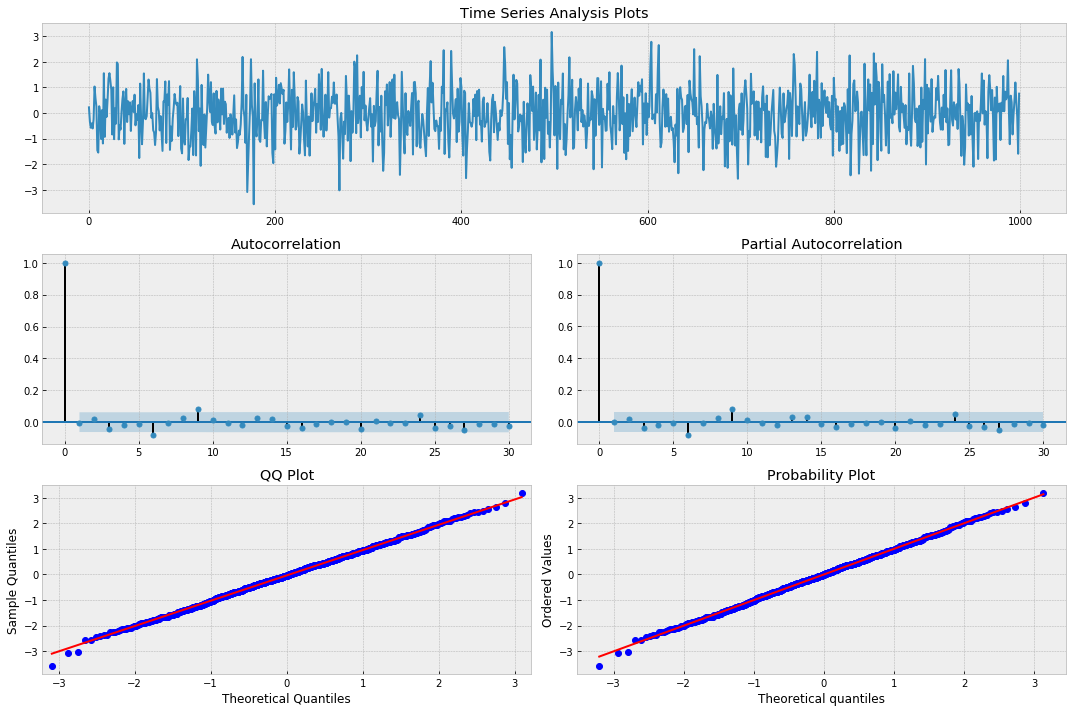

In [8]:
np.random.seed(19)

# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

##### A word on the plots here:
* The top plot is the values of time series itself
* The second row has plots of autocorrelation (ACF) and partial autocorrelation (PACF). The PACF is partial correlation between residuals, controlling for shorter lags.
  * The x axis shows the values of the lag, $k$ and the blue shaded region show significance boundaries. Only values that lie outside the blue region are significant
* The third row has QQ plots and probability plots
  * QQ plot compares two probability distributions by plotting their quantiles against each other - If the two distributions are similar (orlinearly related), the points in the Q–Q plot will approximately lie on a line. For this discussion, we are comparing the distribution of our residuals with a normal distribution
  * Similarly, normal probability plot also asseses whether or not a data set is approximately normally distributed. The data are plotted against a theoretical normal distribution in such a way that the points should form an approximate straight line. Departures from this straight line indicate departures from normality.

We note the following:

* The process appears to be random and centered about zero
* The autocorrelation (ACF) and partial autocorrelation (PACF) plots also indicate no significant serial correlation (Remember we should see approximately 5% significance in the autocorrelation plots due to pure chance as a result of sampling from the Normal distribution)
* Below that we can see the QQ and Probability Plots, which compares the distribution of our data with standard normal distribution are straight lines

In [9]:
print("Random Series\n -------------\nmean: %.3f \nvariance: %.3f \nstandard deviation: %.3f"
      %(randser.mean(), randser.var(), randser.std()))

Random Series
 -------------
mean: -0.037 
variance: 0.981 
standard deviation: 0.990


Clearly our data is distributed randomly, and appears to follow Gaussian (Normal) white noise, as it should.

##### Random Walk
A random walk is a time series model where the value of the time series variable increases or decreases (step up or down) with equal probability at each time step, that is the expected value of current observation is equal to the previous observation. It is formally defined below:
$$x_t=x_{t-1}+w_t$$
, where $w_t$ is a discrete white noise series. 
    $$E[x_t]=x_{t-1}$$

This means if the TS we are modeling is a random walk it is unpredictable, as they are literally random walks.

The significance of a random walk is that it is non-stationary because while the mean of a random walk is still zero, the covariance is actually time-dependent. In particular, the covariance is equal to the variance multiplied by the time. Hence, as time increases, so does the variance.

Let's simulate a random walk

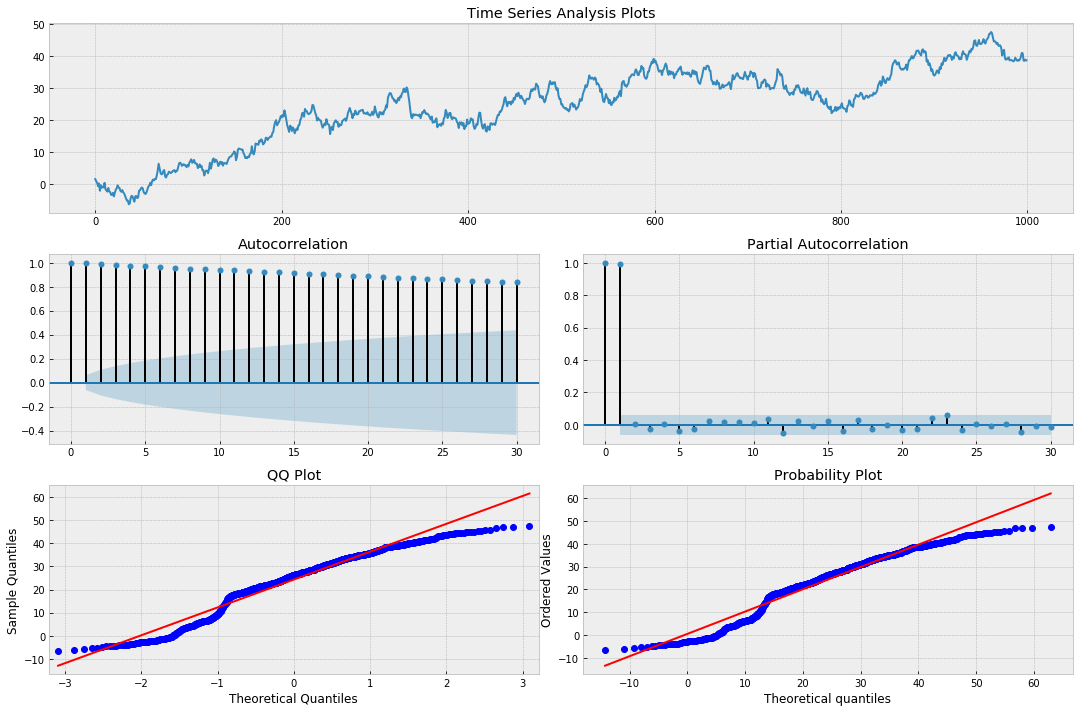

In [10]:
# Random Walk without a drift

np.random.seed(1)
n_samples = 1000

x = w = np.random.normal(size=n_samples)
for t in range(n_samples):
    x[t] = x[t-1] + w[t]

_ = tsplot(x, lags=30)

Clearly our TS is not stationary. How to check if the random walk model is a good fit for our simulated data? We have
$$x_t - x_{t-1} = w_t$$

, where $w_t$ is a discrete white noise series.

The first differences of our random walk series should equal a white noise process!

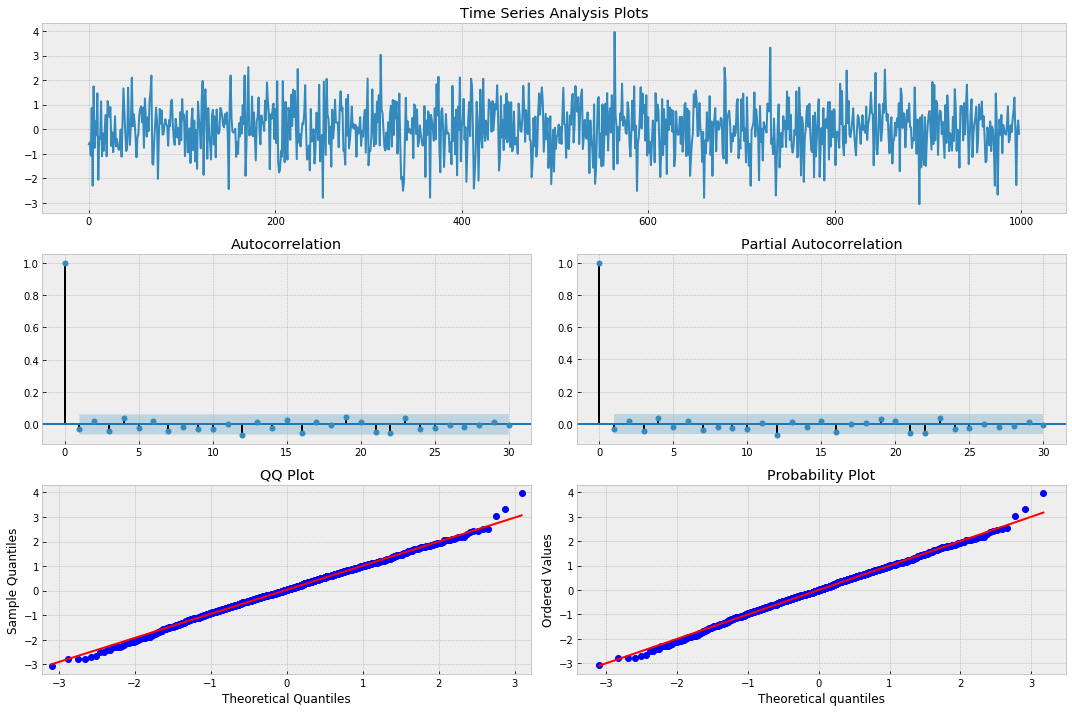

In [11]:
# First difference of simulated Random Walk series
_ = tsplot(np.diff(x), lags=30)

As expected, the difference is indeed white noise.

Let's now apply our random walk model to some actual financial data.

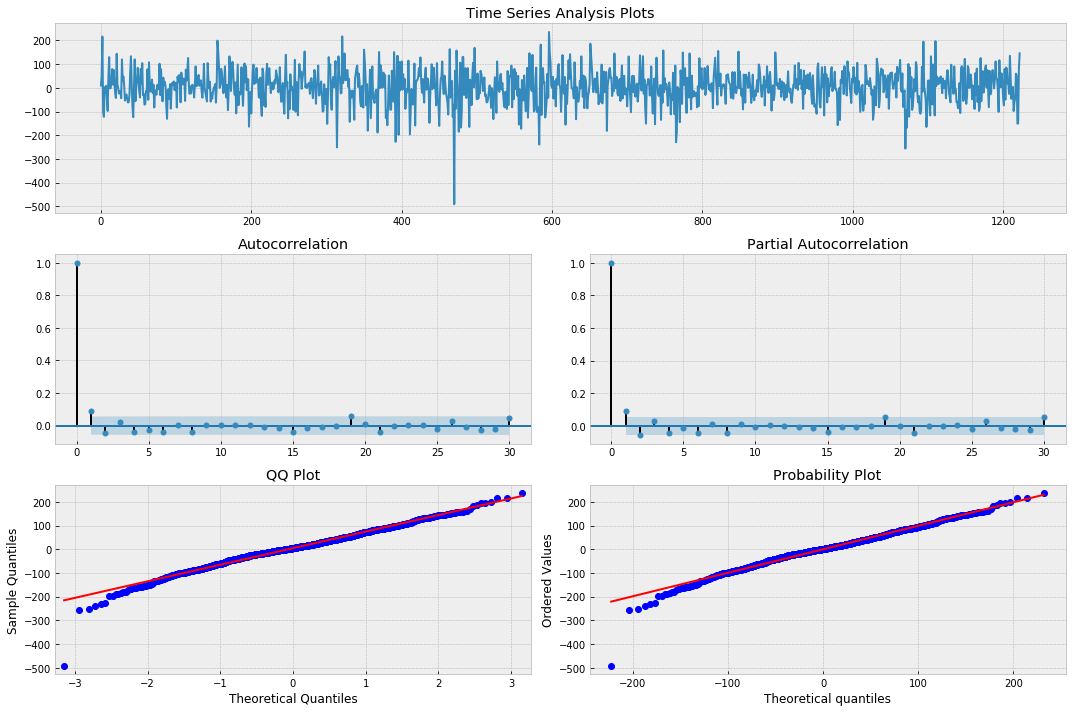

In [12]:
# First difference of NIFTY prices
_ = tsplot(np.diff(data_nifty['Adj Close']), lags=30)

It's quite similar to white noise, isn't it?

The shape of the QQ and Probability plots. This indicates that the process is close to normality but with 'heavy tails'. This means that there should be better models to explain the price of NIFTY.

Let's try the same on other equities'

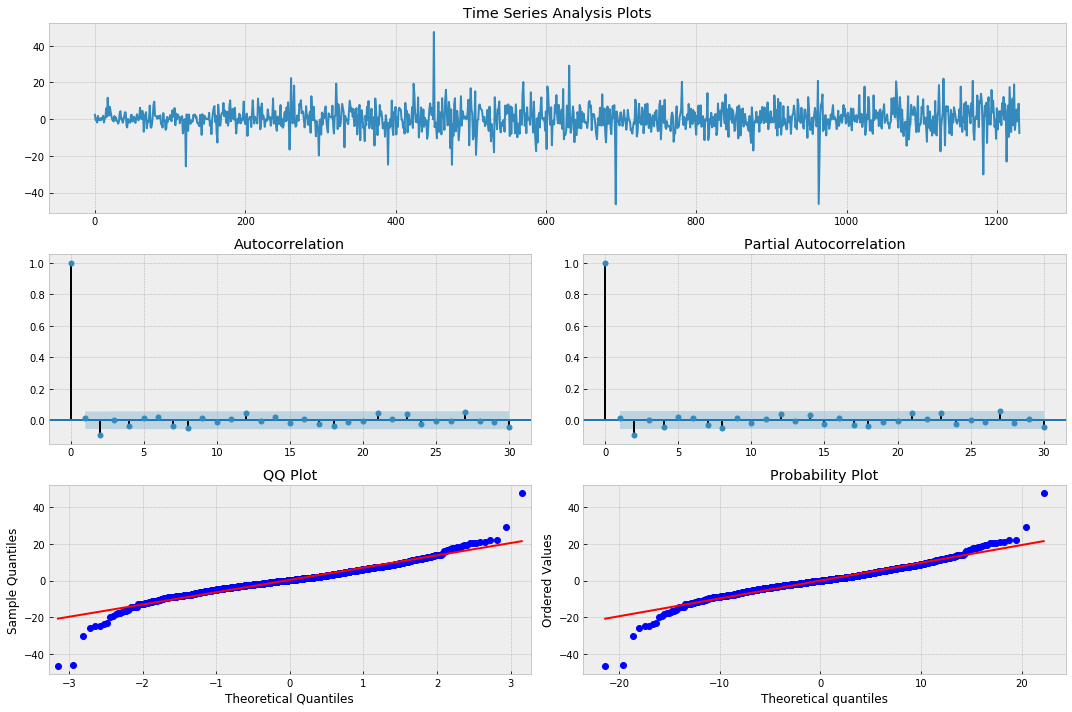

In [13]:
# First difference of INFY prices
_ = tsplot(np.diff(data_infy['Adj Close']), lags=30)

Again the time series is quite similar to white noise with similar 'heavy tails'.

Before we conclude, let's talk about two more simple TS models.

###### Linear Models

Linear models aka trend models represent a TS that can be graphed using a straight line. The basic equation is: $$x_{t} = a_0+a_1 t + b$$

The value of the time series is determined by the coefficients, $a_0, a_1$ and time. An example could be a company's sales that increase by the same amount at each time step. For a hypthtical example, consider a company who's stock price was a 100$ to start, and increase by 50c at every time step.

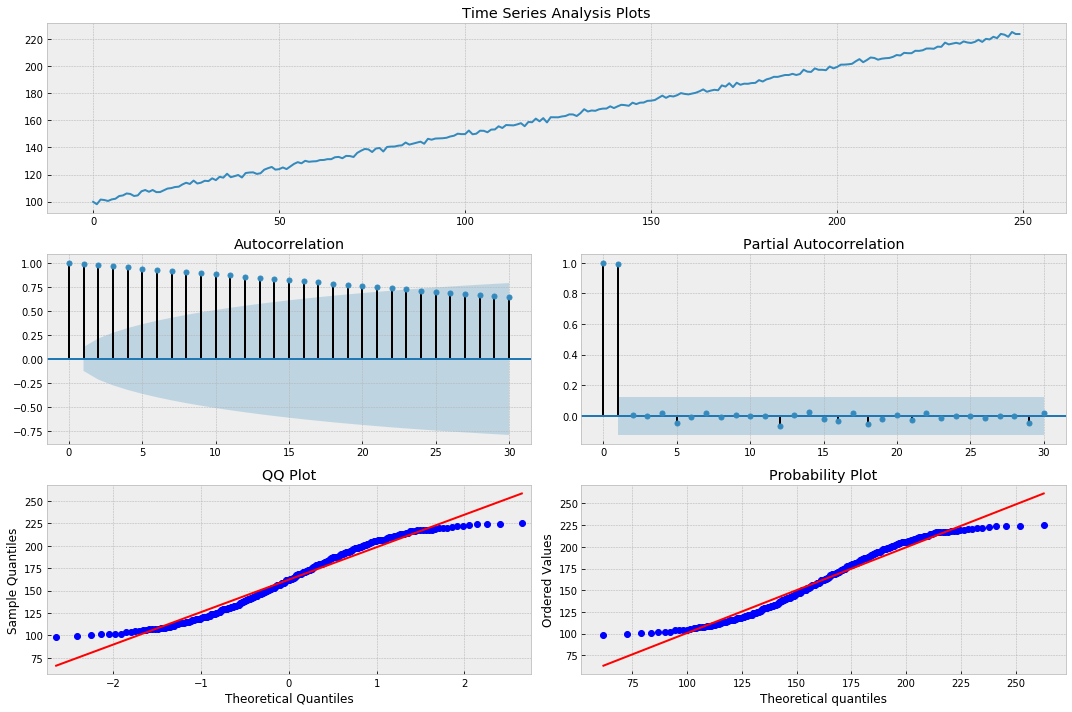

In [14]:
# simulate linear trend

w = np.random.randn(250)
x = np.empty_like(w)

a0 = 100.
a1 = 0.5
for t in range(len(w)):
    x[t] = a0 + a1*t + w[t]
    
_ = tsplot(x, lags=30)

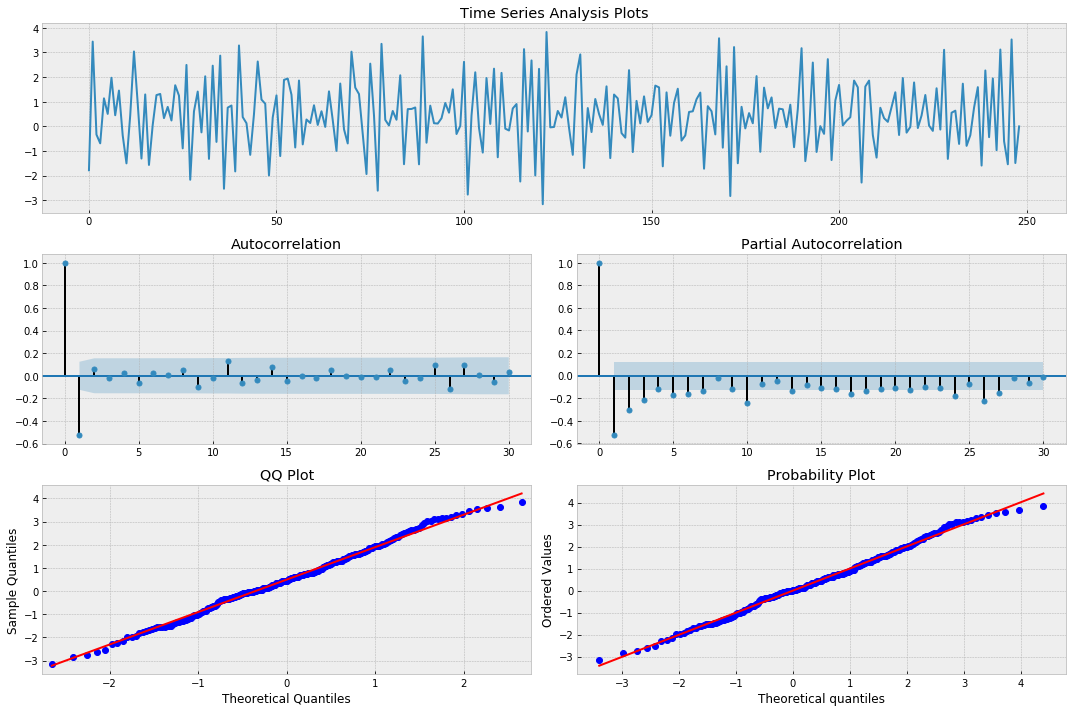

In [15]:
# First difference of simulated prices
_ = tsplot(np.diff(x), lags=30)

Here we can see that the residuals of the model are correlated. Though the distribution is approximately normal, before using this model to make predictions we would have to account for and remove the obvious autocorrelation (the significant value at lag 1) present in the series. The significance of the PACF at lag 1 indicates that an autoregressive model may be appropriate


###### Log-Linear Models

Similar to linear models except that the TS that can be graphed using an exponential function. That is the the time series has a constant rate of change with respect to each time step. $$x_{t} = exp(a_0+a_1 t)$$$$log(x_{t}) = a_0+a_1 t$$$$x_0 = exp(a_0)$$$$x_t = x_{t-1}*exp(a1)$$ 

For example, in our above simulated series, if the stock price increased by X% at each time step, you get a curve that looks like this:

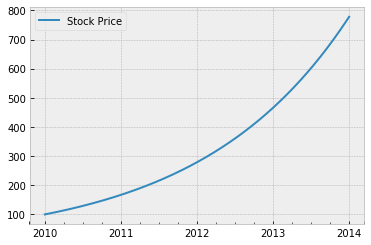

In [16]:
# Simulate exponential growth

idx = pd.date_range('2010-01-01', '2014-01-01', freq='D')
price = [np.exp( 4.605 + float(x)/712 ) for x in range(0, len(idx))]

# create dataframe and plot
df = pd.DataFrame(price, columns=['Stock Price'], index=idx)

with plt.style.context('bmh'):
    df.plot()

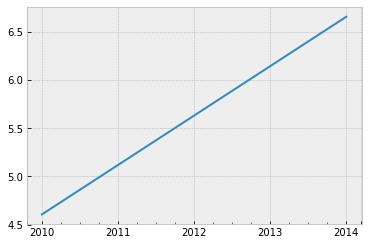

In [17]:
# log of prices

with plt.style.context('bmh'):
    pd.Series(np.log(price), index=idx).plot()

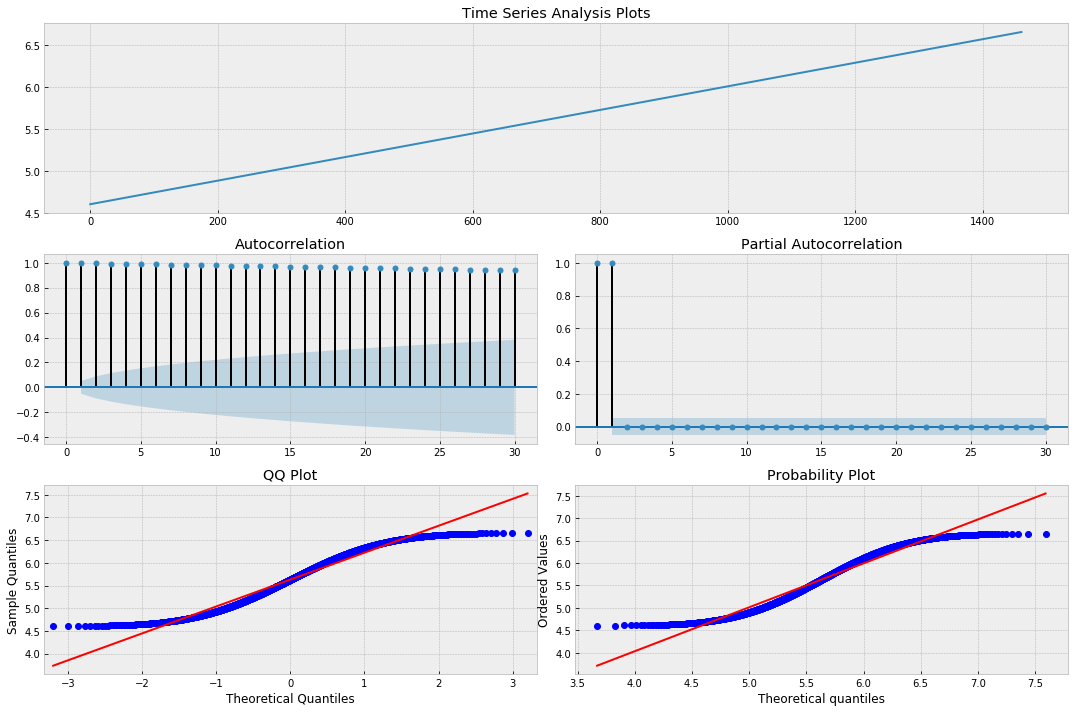

In [18]:
_ = tsplot(np.log(price), lags=30)

###### Autoregressive Models of order p $AR(p)$
The autoregressive model is simply an extension of the random walk. It is essentially a regression model which depends linearly on the previous terms: $$x_t = \alpha_1x_{t-1}+…+\alpha_px_{t-p}+w_t = \sum_{i=1}^{p} t_i\alpha_ix_{t-i}+w_t$$

This is an AR model of order "p",where $p$ represents the number of previous (or lagged) terms used within the model, $\alpha_i$ is the coefficient, and $w_t$ is a white noise term. Note that an AR(1) model with $\alpha_1$ set equal to 1 is a random walk!

One of the most important aspects of the AR(p) model is that it is not always stationary. The stationarity of a particular model depends upon the parameters. For example, an AR(1) model with $\alpha_1$ = 1 is a random walk and therefore not stationary.

Let's simulate an AR(1) model with $\alpha$ set equal to 0.6

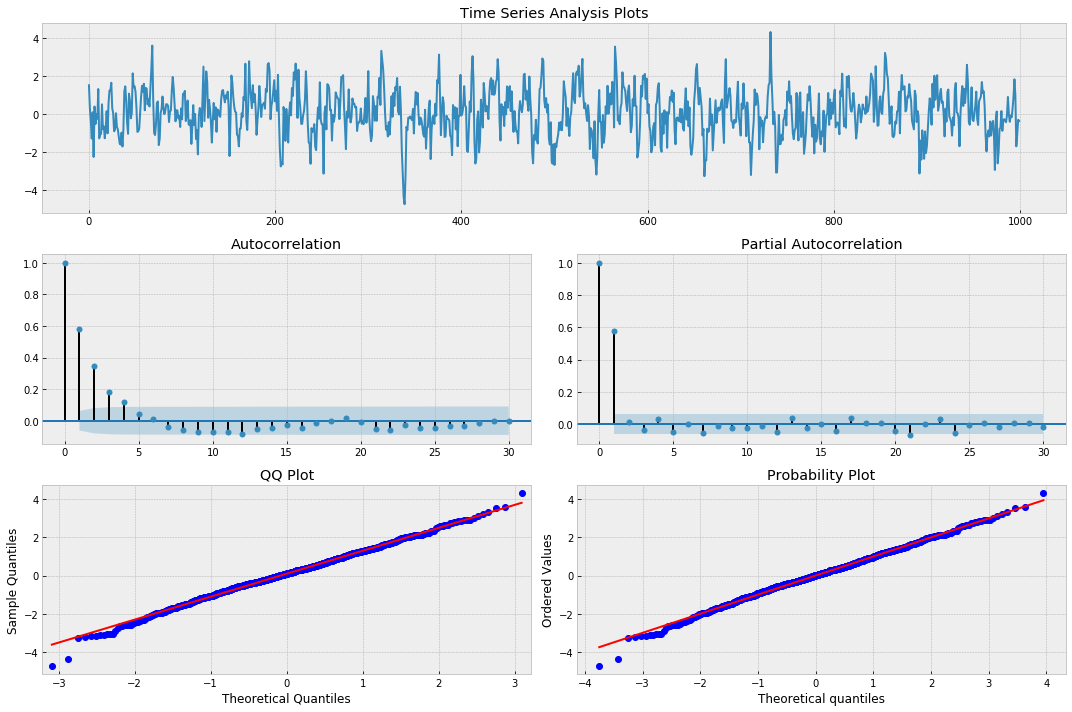

In [19]:
# Simulate an AR(1) process with a = 0.6

np.random.seed(1)
n_samples = int(1000)
a = 0.6
x = w = np.random.normal(size=n_samples)

for t in range(n_samples):
    x[t] = a*x[t-1] + w[t]
    
_ = tsplot(x, lags=30)

Note the distribution of our simulated AR(1) model is normal but there is significant serial correlation between lagged values visible in the ACF and PACF plots.

PACF plots are used to identify the extent of the lag in an autoregressive mode. If we find no significant correlation in a PACF plot after lag $k$, an AR(k) model is usually a good fit. Looking at this chart, we can hypothesize that a AR(1) model should fit.

###### Data Fitting

Now we can fit an AR(p) model using Python's statsmodels to estimate the alpha coefficient and order. If the AR model is correct the estimated alpha coefficient will be close to our true alpha of 0.6 and the selected order will equal 1.

In [20]:
# Fit an AR(p) model to simulated AR(1) model with alpha = 0.6

mdl = sm.tsa.AR(x).fit(maxlag=30, ic='aic', trend='nc')
est_order = sm.tsa.AR(x).select_order( maxlag=30, ic='aic', trend='nc')

true_order = 1
print('\nalpha estimate: %3.5f | order_estimate %s'%(mdl.params, est_order))
print('\ntrue alpha = %s | true order = %s'%(a, true_order))


alpha estimate: 0.58227 | order_estimate 1

true alpha = 0.6 | true order = 1


Looks like we were able to recover the underlying parameters of our simulated data.

Let's simulate an AR(2) process with $\alpha_1$ = 0.666 and $\alpha_2$ = -0.333.

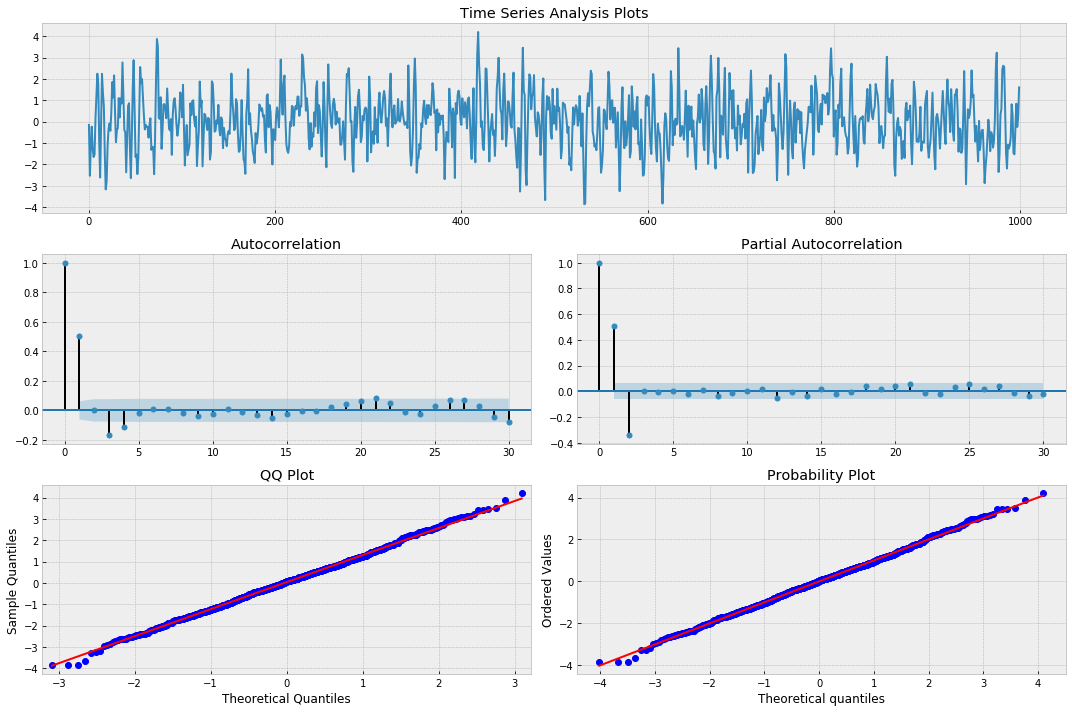

In [21]:
# Simulate an AR(2) process

n = int(1000)
alphas = np.array([.666, -.333])
betas = np.array([0.])

# Python requires us to specify the zero-lag value which is 1
# Also note that the alphas for the AR model must be negated
# We also set the betas for the MA equal to 0 for an AR(p) model
# For more information see the examples at statsmodels.org
ar = np.r_[1, -alphas]
ma = np.r_[1, betas]

ar2 = smt.arma_generate_sample(ar=ar, ma=ma, nsample=n) 
_ = tsplot(ar2, lags=30)

There is significant serial correlation between lagged values at lag 1 and 2 now, as evidenced by the PACF plot.Let's see if we recover the underlying parameters of our simulated data.

In [22]:
# Fit an AR(p) model to simulated AR(2) process

max_lag = 10
mdl = smt.AR(ar2).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(ar2).select_order( maxlag=max_lag, ic='aic', trend='nc')

true_order = 2
print('\ncoef estimate: %3.4f %3.4f | order estimate %s'%(mdl.params[0],mdl.params[1],est_order))


coef estimate: 0.6760 -0.3393 | order estimate 2


##### Note on choosing the number of lags
If we just naively fit a model, it will estimate quite a few parameters. See below

In [23]:
mdl = smt.AR(ar2).fit()
print ('Parameters')
print (mdl.params)
print ('Standard Error')
print (mdl.bse)

Parameters
[ 3.57345632e-02  6.67118523e-01 -3.40041205e-01  9.01909128e-03
 -1.11520048e-02  2.14435279e-02 -4.83381895e-02  3.28287551e-02
 -2.38531001e-02 -4.90031065e-04 -3.12735473e-02  5.21112625e-02
 -5.85303137e-02  2.17108859e-02 -5.58739239e-02  2.79663351e-02
 -6.45697812e-03 -2.90269682e-02  3.79624698e-02  1.12370300e-02
  2.54545125e-03  5.79634021e-02]
Standard Error
[0.03330767 0.03229192 0.03882052 0.04032568 0.04032737 0.04031148
 0.04030305 0.04029053 0.04027444 0.04025271 0.04022384 0.04018031
 0.0402171  0.04026555 0.04027908 0.04028844 0.04027529 0.04028007
 0.04028697 0.04034915 0.03870137 0.03212717]


In [24]:
N = 10
AIC = np.zeros((N, 1))

for i in range(N):
    model = smt.AR(ar2)
    model = model.fit(maxlag=(i+1))
    AIC[i] = model.aic
    
AIC_min = np.min(AIC)
model_min = np.argmin(AIC)

print ('Number of parameters in minimum AIC model %s' % (model_min+1))

Number of parameters in minimum AIC model 2


##### Evaluating Residuals
The final step after fitting our model is to evaluate its residual behavior. Rememeber we mentioned earlier that our aim is to find a model fit for our time series such that the residuals are white noise.
Let's check for normality of the residuals here.

In [25]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

The residuals seem normally distributed.


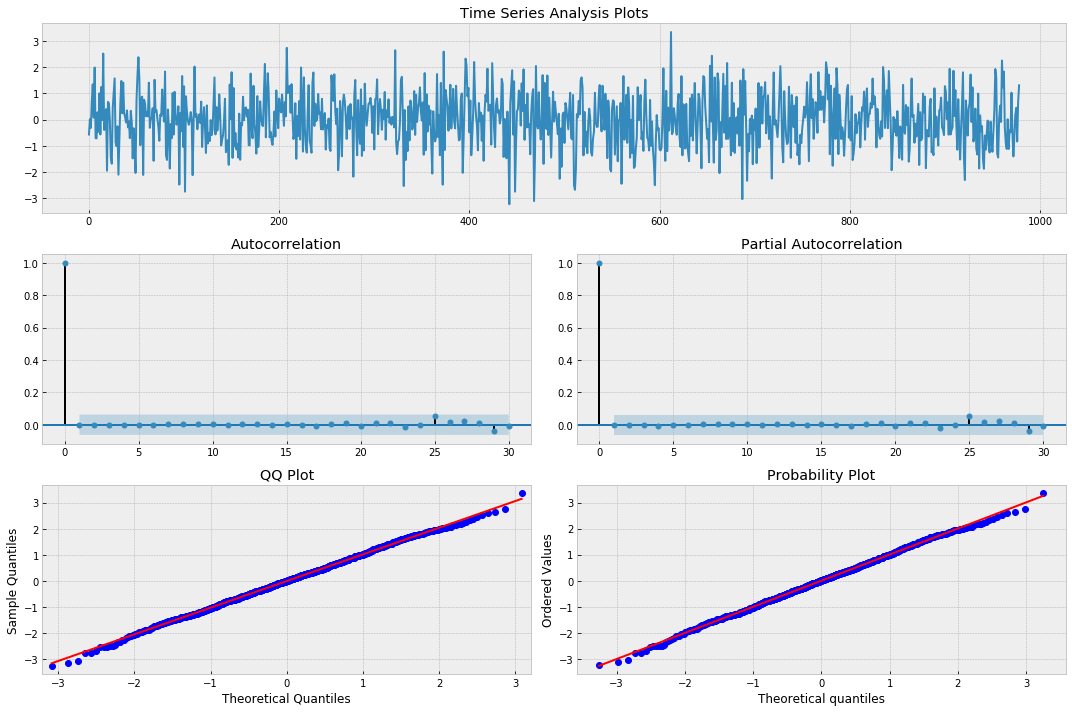

In [26]:
tsplot(mdl.resid, lags=30)

The residuals indeed look like white noise, indicating we have explained the data well with our model

##### Side Note: Fat Tails
Autoregressive processes are more likely to have extreme values than data drawn from a normal distribution. Since the value at each time point is influenced by recent values, if the series randomly jumps up, it is more likely to stay up than a non-autoregressive series. This is known as fat-tailed distribution because the tails (extremes) on PDF will be fatter than in a normal distribution.
AR models are just one of the sources of tail risk, so don't assume that because a series is non-AR, it does not have tail risk.

##### Application to Financial Series
Now let's see how the AR(p) model will fit INFY log returns. Here is the log returns TS.

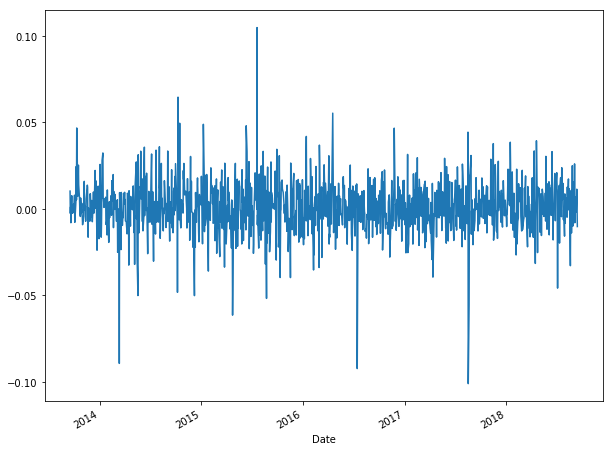

In [27]:
lrets_infy = np.log(data_infy['Adj Close']/data_infy['Adj Close'].shift(1)).dropna()
lrets_infy.plot(figsize=(10,8))

In [28]:
lrets_infy[lrets_infy>0.1]

Date
2015-07-21    0.104847
Name: Adj Close, dtype: float64

In [29]:
print(data_infy.loc['2015-07-21']['Adj Close'])
print(data_infy.loc['2015-07-22']['Adj Close'])
print(data_infy.loc['2015-07-17']['Adj Close'])
print(data_infy.loc['2015-07-20']['Adj Close'])

476.752258
472.44592300000005
429.34051500000004
429.297638


Let's find the best order and also plot the residuals of the model

/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 2


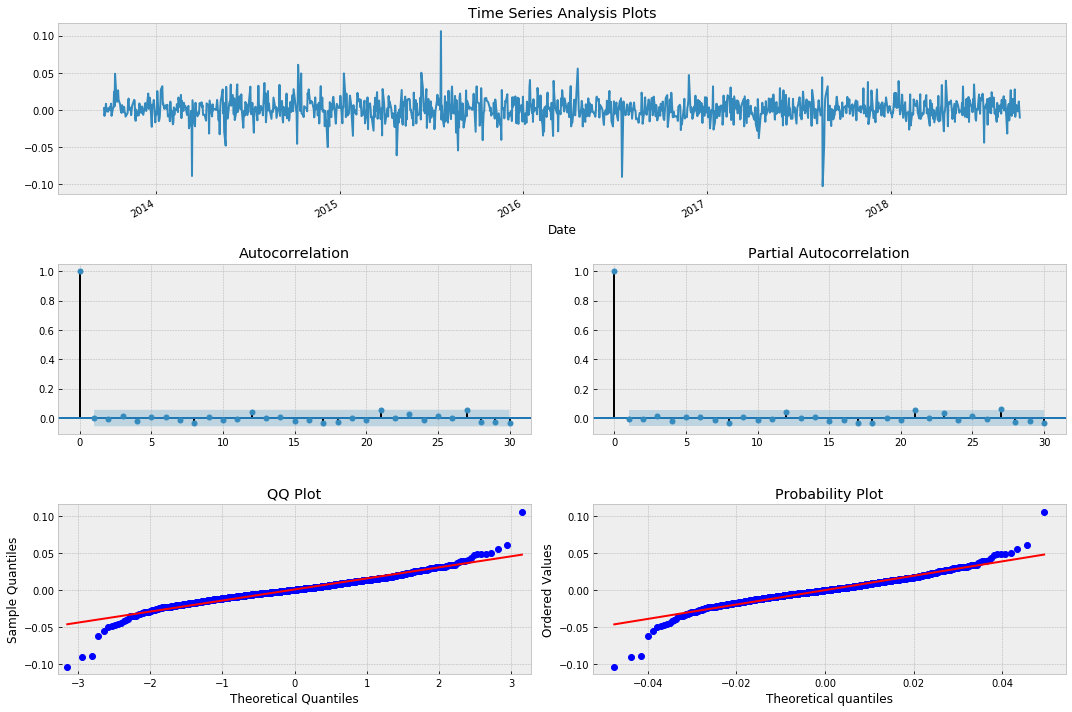

In [30]:
# Select best lag order for INFY returns

max_lag = 30
mdl = smt.AR(lrets_infy).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets_infy).select_order(
    maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))

_ = tsplot(mdl.resid, lags=max_lag)

In [31]:
smt.AR(lrets_infy).select_order

/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<bound method AR.select_order of <statsmodels.tsa.ar_model.AR object at 0x111d7e5c0>>

In [32]:
smt.AR(lrets_infy).select_order

/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


<bound method AR.select_order of <statsmodels.tsa.ar_model.AR object at 0x11b88c860>>

This produces an AR(2) model, 

What does this tell us? It is indicative that there is likely a lot more complexity in the serial correlation than a simple linear model of past prices can really account for. A test of normality on model residuals indicates the same.

In [33]:
from statsmodels.stats.stattools import jarque_bera

score, pvalue, _, _ = jarque_bera(mdl.resid)

if pvalue < 0.10:
    print ('We have reason to suspect the residuals are not normally distributed.')
else:
    print ('The residuals seem normally distributed.')

We have reason to suspect the residuals are not normally distributed.


Finally let's see how the AR(p) model will fit NIFTY log returns. Here is the log returns TS

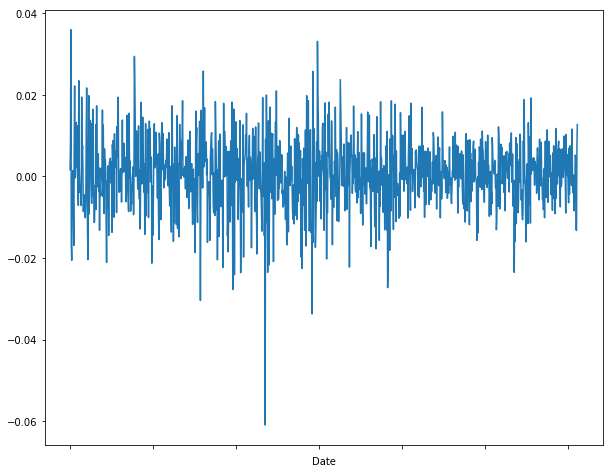

In [34]:
lrets_nifty = np.log(data_nifty['Adj Close']/data_nifty['Adj Close'].shift(1)).dropna()
lrets_nifty.plot(figsize=(10,8))

In [35]:
lrets_nifty[lrets_nifty<-.05]

Date
2015-08-24   -0.060973
Name: Adj Close, dtype: float64

In [36]:
import datetime
print(data_nifty.loc['2015-08-24']['Adj Close'])
print(data_nifty.loc['2015-08-25']['Adj Close'])
print(data_nifty.loc['2015-08-21']['Adj Close'])
print(data_nifty.loc['2015-08-20']['Adj Close'])

7809.0
7880.700195
8299.950195
8372.75


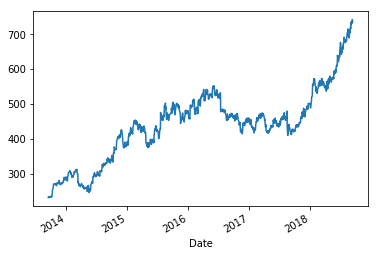

In [37]:
data_infy['Adj Close'].plot()

/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Users/divyasharma/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


best estimated lag order = 1
L1.Adj Close    0.109102
L2.Adj Close   -0.066980
L3.Adj Close    0.039344
L4.Adj Close   -0.045673
dtype: float64


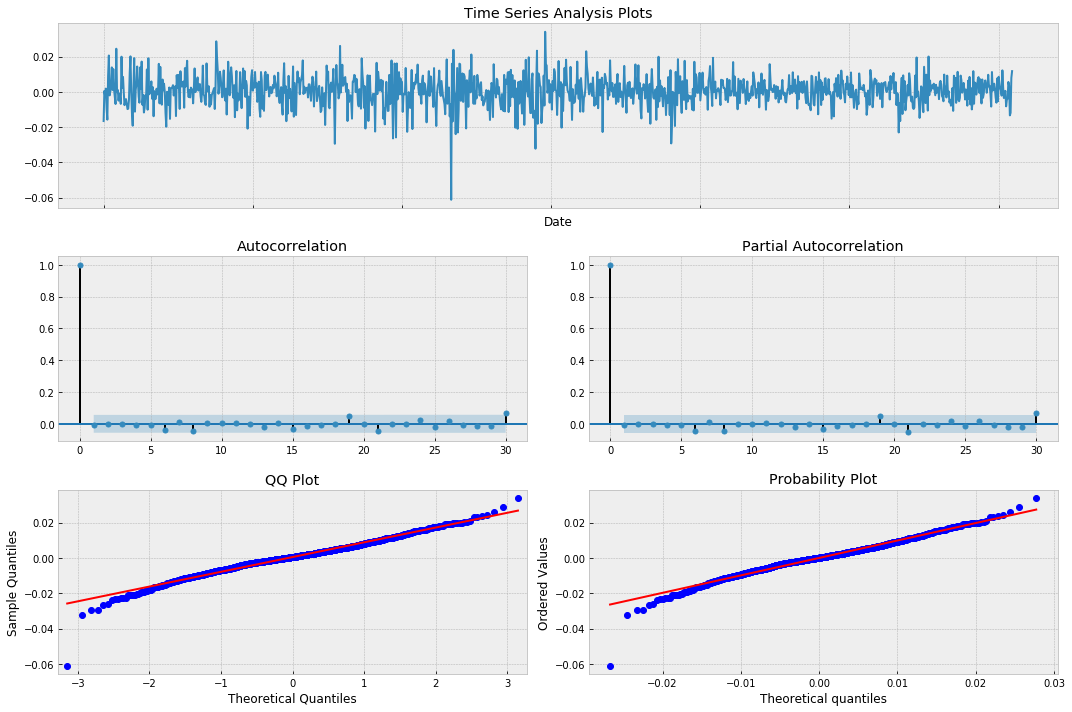

In [38]:
# Select best lag order for SPX returns

max_lag = 30
mdl = smt.AR(lrets_nifty).fit(maxlag=max_lag, ic='aic', trend='nc')
est_order = smt.AR(lrets_nifty).select_order(maxlag=max_lag, ic='aic', trend='nc')

print('best estimated lag order = %s'%(est_order))
print(mdl.params)

_ = tsplot(mdl.resid, lags=max_lag)